### CIFAR10 案例

In [ ]:
# 导入包

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

In [1]:
# 1 数据类型转换
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(), # numpy --> tensor
    transforms.Normalize((0.5,),(0.5,)), # 正则化
    transforms.Resize(10), # 改变大小
    transforms.RandomHorizontalFlip(0.3), # 随机水平翻转
    transforms.RandomVerticalFlip(0.3), # 随机垂直翻转
    transforms.RandomRotation(10), # 随机翻转
    transforms.ColorJitter(0.25,0.25,0.25,0.25) # 亮度、对比度、饱和度、色彩度
])

In [2]:
# 2 下载数据
from torchvision import datasets

"""参数说明：
'./CIFAR10' --> 数据集在本地磁盘的路径
train=True --> 训练集（如果是False，则是测试集）
download=True --> 下载数据集（如果本地已经有数据集，则不下载）
transform=transforms --> 对数据集进行转换
"""
train_dataset = datasets.CIFAR10('./CIFAR10', train=True, download=True, transform=transform)

test_dataset = datasets.CIFAR10('./CIFAR10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 3 数据分离
from torch.utils.data.sampler import SubsetRandomSampler # 根据索引进行采样
import numpy as np

# 设置验证数据集的占比
val_ratio = 0.3

# train的数量
train_size = len(train_dataset)

# train的索引
indices = list(range(train_size))

# 打乱索引
np.random.shuffle(indices)

# 计算验证集的数量, np.floor() 向下取整
val_len = int(np.floor(train_size * val_ratio))

# 分别获取到训练集和验证集的索引
train_indices, val_indices = indices[val_len:], indices[:val_len] 

# 根据索引，分别获取训练集和验证集
train_sample = SubsetRandomSampler(train_indices)
val_sample = SubsetRandomSampler(val_indices)

# 设置batch_size
batch_size = 128

# 以batch_size的方式加载数据
from torch.utils.data.dataloader import DataLoader

# 训练集
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sample, num_workers=16, pin_memory=True)
# 验证集
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sample, num_workers=16, pin_memory=True)
# 测试集
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=16, pin_memory=True)

torch.Size([128, 3, 10, 10]) torch.Size([128])


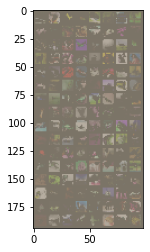

In [4]:
# 显示部分训练集
import torchvision
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    # print(inp.numpy().shape) --> (3, 194, 98)
    inp = inp.numpy().transpose((1,2,0)) # 改变顺序
    mean = np.array([0.485, 0.456, 0.406]) # 均值
    std = np.array([0.229, 0.224, 0.225]) # 标准差
    inp = std * inp + mean # 逆向复原
    inp = np.clip(inp, 0, 1) # np.clip() 将inp中的元素值限制在(0,1)之间，最小值为0，最大值为1。小于min的等于min，大于max等于max
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)
    
inputs, classes = next(iter(train_loader))

print(inputs.shape, classes.shape)

out = torchvision.utils.make_grid(inputs)

imshow(out)

In [5]:
# 4 定义网络结构
import torch.nn as nn
import torch.nn.functional as F

class CIFAR_Model(nn.Module):
    # 定义构造方法
    # 特征图尺寸的计算公式为：[(原图片尺寸 — 卷积核尺寸) / 步长 ] + 1
    def __init__(self):
        # 调用父类的构造方法
        super(CIFAR_Model, self).__init__()
        # 卷基层1
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # 3:通道，16：输出，3：kernel size
        # 卷基层2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16：输入，32：输出，3：kernel size
        # 卷基层3
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 32：输入，64：输出，3：kernel size
        # 最大池化层
        self.pool = nn.MaxPool2d(2, 2) # 2：kernel size，2：步长
        # 全连接层1
        self.linear1 = nn.Linear(64, 512) # 64:输入，512:输出
        # 全连接层2
        self.linear2 = nn.Linear(512, 10) # 512:输入，10:输出
        # dropout 层
        self.dropout = nn.Dropout(p=0.3) # 丢掉30%的神经元
    
    # 前向传播
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        # 拉平
        x = x.view(-1, 64)
        #print(x.shape)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [6]:
# 5 训练、验证模型
import torch
import torch.optim as optim

# 部署到device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device.type)

# 创建模型，并部署到device
model = CIFAR_Model().to(device)

# 损失函数
criterion = nn.CrossEntropyLoss()

# 优化器,lr：学习率
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 输出默认值
print(optimizer.defaults)

# 次数
epochs = 10000

# 训练
for epoch in range(1, epochs+1):
    train_loss = 0 # 训练损失
    val_loss = 0 # 验证损失
    model.train()
    for batch_id, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # 梯度置零
        optimizer.zero_grad()
        # 输出
        output = model(data)
        #print(model)
        # 损失
        loss = criterion(output, target)
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        # 累计损失
        train_loss += loss.item()*data.size(0)
    
    # 模型验证
    model.eval()
    for batch_id, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        # 预测
        output = model(data)
        # 损失
        loss = criterion(output, target)
        # 累计损失
        val_loss += loss.item()*data.size(0)
    
    # 计算一个epoch的平均损失
    train_loss /= len(train_loader.sampler)
    val_loss /= len(val_loader.sampler)
    
    # 输出模型计算结果
    print("Epoch : {}, Train Loss : {:.3f}, Val Loss : {:.3f}".format(epoch, train_loss, val_loss))
    
    # 模型测试
    model.eval()
    test_loss = 0
    correct = 0 # 正确率
    with torch.no_grad():
        for batch_id, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data) # 预测结果
            # 累计损失
            test_loss += criterion(output, label).item()*data.size(0)
            # 预测概率最大值的索引
            pred_index = output.argmax(dim=1, keepdim=True) 
            # 累计正确数
            correct += pred_index.eq(label.view_as(pred_index)).sum().item()
        # 平均损失
        test_loss /= len(test_loader.dataset)
        # 输出 计算结果
        print("Test loss : {:.4f} , Accuracy : {}%\n".format(test_loss, correct*100/len(test_loader.dataset)))

cuda
{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}
Epoch : 1, Train Loss : 2.303, Val Loss : 2.301
Test loss : 2.3013 , Accuracy : 10.67%

Epoch : 2, Train Loss : 2.301, Val Loss : 2.299
Test loss : 2.2988 , Accuracy : 11.09%

Epoch : 3, Train Loss : 2.298, Val Loss : 2.295
Test loss : 2.2948 , Accuracy : 13.32%

Epoch : 4, Train Loss : 2.293, Val Loss : 2.289
Test loss : 2.2874 , Accuracy : 13.97%

Epoch : 5, Train Loss : 2.285, Val Loss : 2.278
Test loss : 2.2758 , Accuracy : 14.67%

Epoch : 6, Train Loss : 2.273, Val Loss : 2.264
Test loss : 2.2596 , Accuracy : 15.48%

Epoch : 7, Train Loss : 2.258, Val Loss : 2.248
Test loss : 2.2436 , Accuracy : 15.97%

Epoch : 8, Train Loss : 2.243, Val Loss : 2.232
Test loss : 2.2284 , Accuracy : 17.09%

Epoch : 9, Train Loss : 2.228, Val Loss : 2.221
Test loss : 2.2137 , Accuracy : 17.98%

Epoch : 10, Train Loss : 2.220, Val Loss : 2.210
Test loss : 2.2015 , Accuracy : 19.18%

Epoch : 11, Train Loss : 2.207, 

Test loss : 1.7710 , Accuracy : 35.17%

Epoch : 93, Train Loss : 1.810, Val Loss : 1.794
Test loss : 1.7727 , Accuracy : 35.59%

Epoch : 94, Train Loss : 1.813, Val Loss : 1.805
Test loss : 1.7838 , Accuracy : 35.31%

Epoch : 95, Train Loss : 1.805, Val Loss : 1.792
Test loss : 1.7625 , Accuracy : 36.75%

Epoch : 96, Train Loss : 1.808, Val Loss : 1.785
Test loss : 1.7685 , Accuracy : 35.58%

Epoch : 97, Train Loss : 1.799, Val Loss : 1.783
Test loss : 1.7610 , Accuracy : 36.16%

Epoch : 98, Train Loss : 1.804, Val Loss : 1.781
Test loss : 1.7568 , Accuracy : 36.97%

Epoch : 99, Train Loss : 1.800, Val Loss : 1.775
Test loss : 1.7515 , Accuracy : 36.63%

Epoch : 100, Train Loss : 1.801, Val Loss : 1.852
Test loss : 1.8381 , Accuracy : 34.99%

Epoch : 101, Train Loss : 1.800, Val Loss : 1.771
Test loss : 1.7465 , Accuracy : 37.15%

Epoch : 102, Train Loss : 1.797, Val Loss : 1.814
Test loss : 1.7891 , Accuracy : 35.3%

Epoch : 103, Train Loss : 1.793, Val Loss : 1.786
Test loss : 1.7722

Epoch : 184, Train Loss : 1.695, Val Loss : 1.671
Test loss : 1.6616 , Accuracy : 40.59%

Epoch : 185, Train Loss : 1.697, Val Loss : 1.724
Test loss : 1.7040 , Accuracy : 38.97%

Epoch : 186, Train Loss : 1.692, Val Loss : 1.674
Test loss : 1.6539 , Accuracy : 40.44%

Epoch : 187, Train Loss : 1.694, Val Loss : 1.677
Test loss : 1.6567 , Accuracy : 40.48%

Epoch : 188, Train Loss : 1.697, Val Loss : 1.703
Test loss : 1.6846 , Accuracy : 39.54%

Epoch : 189, Train Loss : 1.695, Val Loss : 1.684
Test loss : 1.6656 , Accuracy : 40.56%

Epoch : 190, Train Loss : 1.696, Val Loss : 1.671
Test loss : 1.6592 , Accuracy : 40.54%

Epoch : 191, Train Loss : 1.691, Val Loss : 1.679
Test loss : 1.6616 , Accuracy : 40.5%

Epoch : 192, Train Loss : 1.690, Val Loss : 1.665
Test loss : 1.6512 , Accuracy : 41.01%

Epoch : 193, Train Loss : 1.691, Val Loss : 1.667
Test loss : 1.6547 , Accuracy : 40.75%

Epoch : 194, Train Loss : 1.687, Val Loss : 1.675
Test loss : 1.6583 , Accuracy : 40.63%

Epoch : 195

Test loss : 1.6395 , Accuracy : 41.23%

Epoch : 276, Train Loss : 1.643, Val Loss : 1.627
Test loss : 1.6159 , Accuracy : 42.28%

Epoch : 277, Train Loss : 1.646, Val Loss : 1.654
Test loss : 1.6381 , Accuracy : 41.1%

Epoch : 278, Train Loss : 1.641, Val Loss : 1.645
Test loss : 1.6353 , Accuracy : 41.43%

Epoch : 279, Train Loss : 1.645, Val Loss : 1.626
Test loss : 1.6230 , Accuracy : 42.3%

Epoch : 280, Train Loss : 1.640, Val Loss : 1.642
Test loss : 1.6350 , Accuracy : 41.33%

Epoch : 281, Train Loss : 1.640, Val Loss : 1.629
Test loss : 1.6118 , Accuracy : 42.34%

Epoch : 282, Train Loss : 1.638, Val Loss : 1.628
Test loss : 1.6226 , Accuracy : 42.23%

Epoch : 283, Train Loss : 1.638, Val Loss : 1.632
Test loss : 1.6123 , Accuracy : 42.2%

Epoch : 284, Train Loss : 1.636, Val Loss : 1.639
Test loss : 1.6194 , Accuracy : 42.43%

Epoch : 285, Train Loss : 1.638, Val Loss : 1.632
Test loss : 1.6185 , Accuracy : 41.67%

Epoch : 286, Train Loss : 1.635, Val Loss : 1.637
Test loss : 1

Epoch : 367, Train Loss : 1.607, Val Loss : 1.606
Test loss : 1.5911 , Accuracy : 42.65%

Epoch : 368, Train Loss : 1.610, Val Loss : 1.600
Test loss : 1.5833 , Accuracy : 43.16%

Epoch : 369, Train Loss : 1.614, Val Loss : 1.608
Test loss : 1.5879 , Accuracy : 42.8%

Epoch : 370, Train Loss : 1.609, Val Loss : 1.608
Test loss : 1.5903 , Accuracy : 42.93%

Epoch : 371, Train Loss : 1.609, Val Loss : 1.604
Test loss : 1.5918 , Accuracy : 43.06%

Epoch : 372, Train Loss : 1.611, Val Loss : 1.608
Test loss : 1.6005 , Accuracy : 42.62%

Epoch : 373, Train Loss : 1.612, Val Loss : 1.608
Test loss : 1.5906 , Accuracy : 43.35%

Epoch : 374, Train Loss : 1.612, Val Loss : 1.624
Test loss : 1.6097 , Accuracy : 41.95%

Epoch : 375, Train Loss : 1.608, Val Loss : 1.614
Test loss : 1.5922 , Accuracy : 43.3%

Epoch : 376, Train Loss : 1.612, Val Loss : 1.613
Test loss : 1.5913 , Accuracy : 42.9%

Epoch : 377, Train Loss : 1.606, Val Loss : 1.612
Test loss : 1.5884 , Accuracy : 42.93%

Epoch : 378, 

Test loss : 1.5824 , Accuracy : 43.03%

Epoch : 459, Train Loss : 1.590, Val Loss : 1.600
Test loss : 1.5825 , Accuracy : 42.58%

Epoch : 460, Train Loss : 1.593, Val Loss : 1.605
Test loss : 1.5791 , Accuracy : 43.53%

Epoch : 461, Train Loss : 1.593, Val Loss : 1.588
Test loss : 1.5771 , Accuracy : 43.79%

Epoch : 462, Train Loss : 1.590, Val Loss : 1.611
Test loss : 1.5961 , Accuracy : 43.17%

Epoch : 463, Train Loss : 1.586, Val Loss : 1.594
Test loss : 1.5796 , Accuracy : 43.7%

Epoch : 464, Train Loss : 1.584, Val Loss : 1.607
Test loss : 1.5930 , Accuracy : 42.79%

Epoch : 465, Train Loss : 1.585, Val Loss : 1.592
Test loss : 1.5848 , Accuracy : 42.98%

Epoch : 466, Train Loss : 1.585, Val Loss : 1.592
Test loss : 1.5750 , Accuracy : 44.04%

Epoch : 467, Train Loss : 1.590, Val Loss : 1.590
Test loss : 1.5703 , Accuracy : 43.5%

Epoch : 468, Train Loss : 1.590, Val Loss : 1.589
Test loss : 1.5753 , Accuracy : 43.29%

Epoch : 469, Train Loss : 1.585, Val Loss : 1.607
Test loss : 

Epoch : 550, Train Loss : 1.575, Val Loss : 1.597
Test loss : 1.5812 , Accuracy : 42.99%

Epoch : 551, Train Loss : 1.569, Val Loss : 1.594
Test loss : 1.5720 , Accuracy : 44.1%

Epoch : 552, Train Loss : 1.574, Val Loss : 1.585
Test loss : 1.5679 , Accuracy : 43.43%

Epoch : 553, Train Loss : 1.570, Val Loss : 1.583
Test loss : 1.5646 , Accuracy : 44.27%

Epoch : 554, Train Loss : 1.573, Val Loss : 1.577
Test loss : 1.5615 , Accuracy : 43.83%

Epoch : 555, Train Loss : 1.573, Val Loss : 1.575
Test loss : 1.5688 , Accuracy : 44.35%

Epoch : 556, Train Loss : 1.573, Val Loss : 1.582
Test loss : 1.5676 , Accuracy : 44.2%

Epoch : 557, Train Loss : 1.571, Val Loss : 1.592
Test loss : 1.5842 , Accuracy : 43.23%

Epoch : 558, Train Loss : 1.571, Val Loss : 1.580
Test loss : 1.5598 , Accuracy : 43.86%

Epoch : 559, Train Loss : 1.576, Val Loss : 1.592
Test loss : 1.5619 , Accuracy : 43.93%

Epoch : 560, Train Loss : 1.569, Val Loss : 1.584
Test loss : 1.5722 , Accuracy : 43.21%

Epoch : 561,

Test loss : 1.5636 , Accuracy : 44.27%

Epoch : 642, Train Loss : 1.560, Val Loss : 1.576
Test loss : 1.5525 , Accuracy : 44.62%

Epoch : 643, Train Loss : 1.560, Val Loss : 1.569
Test loss : 1.5557 , Accuracy : 44.43%

Epoch : 644, Train Loss : 1.559, Val Loss : 1.578
Test loss : 1.5566 , Accuracy : 44.48%

Epoch : 645, Train Loss : 1.557, Val Loss : 1.589
Test loss : 1.5744 , Accuracy : 43.9%

Epoch : 646, Train Loss : 1.558, Val Loss : 1.583
Test loss : 1.5533 , Accuracy : 44.6%

Epoch : 647, Train Loss : 1.560, Val Loss : 1.583
Test loss : 1.5588 , Accuracy : 44.42%

Epoch : 648, Train Loss : 1.559, Val Loss : 1.572
Test loss : 1.5548 , Accuracy : 44.39%

Epoch : 649, Train Loss : 1.556, Val Loss : 1.579
Test loss : 1.5610 , Accuracy : 44.49%

Epoch : 650, Train Loss : 1.556, Val Loss : 1.587
Test loss : 1.5729 , Accuracy : 43.44%

Epoch : 651, Train Loss : 1.556, Val Loss : 1.576
Test loss : 1.5538 , Accuracy : 44.23%

Epoch : 652, Train Loss : 1.556, Val Loss : 1.574
Test loss : 

Epoch : 733, Train Loss : 1.546, Val Loss : 1.566
Test loss : 1.5503 , Accuracy : 44.6%

Epoch : 734, Train Loss : 1.549, Val Loss : 1.562
Test loss : 1.5638 , Accuracy : 44.31%

Epoch : 735, Train Loss : 1.546, Val Loss : 1.587
Test loss : 1.5595 , Accuracy : 43.62%

Epoch : 736, Train Loss : 1.543, Val Loss : 1.606
Test loss : 1.5821 , Accuracy : 43.63%

Epoch : 737, Train Loss : 1.542, Val Loss : 1.579
Test loss : 1.5651 , Accuracy : 43.47%

Epoch : 738, Train Loss : 1.550, Val Loss : 1.574
Test loss : 1.5586 , Accuracy : 43.66%

Epoch : 739, Train Loss : 1.549, Val Loss : 1.568
Test loss : 1.5557 , Accuracy : 44.72%

Epoch : 740, Train Loss : 1.549, Val Loss : 1.566
Test loss : 1.5578 , Accuracy : 43.67%

Epoch : 741, Train Loss : 1.547, Val Loss : 1.583
Test loss : 1.5690 , Accuracy : 44.02%

Epoch : 742, Train Loss : 1.549, Val Loss : 1.583
Test loss : 1.5728 , Accuracy : 43.56%

Epoch : 743, Train Loss : 1.548, Val Loss : 1.572
Test loss : 1.5588 , Accuracy : 44.05%

Epoch : 744

Test loss : 1.5463 , Accuracy : 44.17%

Epoch : 825, Train Loss : 1.539, Val Loss : 1.569
Test loss : 1.5471 , Accuracy : 44.39%

Epoch : 826, Train Loss : 1.539, Val Loss : 1.573
Test loss : 1.5559 , Accuracy : 44.13%

Epoch : 827, Train Loss : 1.538, Val Loss : 1.565
Test loss : 1.5477 , Accuracy : 44.94%

Epoch : 828, Train Loss : 1.537, Val Loss : 1.566
Test loss : 1.5441 , Accuracy : 44.89%

Epoch : 829, Train Loss : 1.538, Val Loss : 1.570
Test loss : 1.5428 , Accuracy : 45.13%

Epoch : 830, Train Loss : 1.538, Val Loss : 1.566
Test loss : 1.5455 , Accuracy : 44.96%

Epoch : 831, Train Loss : 1.545, Val Loss : 1.568
Test loss : 1.5464 , Accuracy : 44.35%

Epoch : 832, Train Loss : 1.536, Val Loss : 1.574
Test loss : 1.5469 , Accuracy : 44.56%

Epoch : 833, Train Loss : 1.536, Val Loss : 1.563
Test loss : 1.5454 , Accuracy : 44.86%

Epoch : 834, Train Loss : 1.532, Val Loss : 1.564
Test loss : 1.5393 , Accuracy : 45.03%

Epoch : 835, Train Loss : 1.539, Val Loss : 1.561
Test loss 

Epoch : 916, Train Loss : 1.529, Val Loss : 1.565
Test loss : 1.5413 , Accuracy : 44.76%

Epoch : 917, Train Loss : 1.532, Val Loss : 1.563
Test loss : 1.5467 , Accuracy : 44.68%

Epoch : 918, Train Loss : 1.533, Val Loss : 1.566
Test loss : 1.5509 , Accuracy : 44.85%

Epoch : 919, Train Loss : 1.530, Val Loss : 1.562
Test loss : 1.5455 , Accuracy : 44.96%

Epoch : 920, Train Loss : 1.529, Val Loss : 1.575
Test loss : 1.5688 , Accuracy : 44.02%

Epoch : 921, Train Loss : 1.527, Val Loss : 1.562
Test loss : 1.5326 , Accuracy : 45.4%

Epoch : 922, Train Loss : 1.525, Val Loss : 1.564
Test loss : 1.5482 , Accuracy : 44.98%

Epoch : 923, Train Loss : 1.526, Val Loss : 1.559
Test loss : 1.5422 , Accuracy : 44.88%

Epoch : 924, Train Loss : 1.534, Val Loss : 1.575
Test loss : 1.5608 , Accuracy : 44.04%

Epoch : 925, Train Loss : 1.529, Val Loss : 1.559
Test loss : 1.5512 , Accuracy : 44.55%

Epoch : 926, Train Loss : 1.532, Val Loss : 1.563
Test loss : 1.5525 , Accuracy : 44.77%

Epoch : 927

Test loss : 1.5685 , Accuracy : 44.97%

Epoch : 1008, Train Loss : 1.526, Val Loss : 1.565
Test loss : 1.5480 , Accuracy : 44.77%

Epoch : 1009, Train Loss : 1.526, Val Loss : 1.557
Test loss : 1.5369 , Accuracy : 45.12%

Epoch : 1010, Train Loss : 1.521, Val Loss : 1.557
Test loss : 1.5389 , Accuracy : 45.31%

Epoch : 1011, Train Loss : 1.517, Val Loss : 1.563
Test loss : 1.5409 , Accuracy : 44.8%

Epoch : 1012, Train Loss : 1.520, Val Loss : 1.551
Test loss : 1.5392 , Accuracy : 44.74%

Epoch : 1013, Train Loss : 1.522, Val Loss : 1.560
Test loss : 1.5320 , Accuracy : 45.37%

Epoch : 1014, Train Loss : 1.522, Val Loss : 1.570
Test loss : 1.5382 , Accuracy : 45.33%

Epoch : 1015, Train Loss : 1.525, Val Loss : 1.568
Test loss : 1.5488 , Accuracy : 44.42%

Epoch : 1016, Train Loss : 1.527, Val Loss : 1.562
Test loss : 1.5388 , Accuracy : 44.87%

Epoch : 1017, Train Loss : 1.524, Val Loss : 1.557
Test loss : 1.5463 , Accuracy : 45.28%

Epoch : 1018, Train Loss : 1.522, Val Loss : 1.563


Epoch : 1098, Train Loss : 1.516, Val Loss : 1.561
Test loss : 1.5363 , Accuracy : 45.17%

Epoch : 1099, Train Loss : 1.516, Val Loss : 1.552
Test loss : 1.5356 , Accuracy : 45.16%

Epoch : 1100, Train Loss : 1.515, Val Loss : 1.547
Test loss : 1.5287 , Accuracy : 45.06%

Epoch : 1101, Train Loss : 1.515, Val Loss : 1.569
Test loss : 1.5387 , Accuracy : 44.87%

Epoch : 1102, Train Loss : 1.516, Val Loss : 1.557
Test loss : 1.5354 , Accuracy : 45.04%

Epoch : 1103, Train Loss : 1.518, Val Loss : 1.566
Test loss : 1.5329 , Accuracy : 45.21%

Epoch : 1104, Train Loss : 1.519, Val Loss : 1.579
Test loss : 1.5578 , Accuracy : 44.46%

Epoch : 1105, Train Loss : 1.519, Val Loss : 1.560
Test loss : 1.5383 , Accuracy : 44.94%

Epoch : 1106, Train Loss : 1.518, Val Loss : 1.559
Test loss : 1.5391 , Accuracy : 44.97%

Epoch : 1107, Train Loss : 1.516, Val Loss : 1.553
Test loss : 1.5329 , Accuracy : 45.61%

Epoch : 1108, Train Loss : 1.514, Val Loss : 1.551
Test loss : 1.5298 , Accuracy : 45.3%



Test loss : 1.5382 , Accuracy : 44.9%

Epoch : 1189, Train Loss : 1.514, Val Loss : 1.560
Test loss : 1.5305 , Accuracy : 45.47%

Epoch : 1190, Train Loss : 1.511, Val Loss : 1.558
Test loss : 1.5383 , Accuracy : 45.69%

Epoch : 1191, Train Loss : 1.511, Val Loss : 1.550
Test loss : 1.5314 , Accuracy : 45.82%

Epoch : 1192, Train Loss : 1.510, Val Loss : 1.560
Test loss : 1.5518 , Accuracy : 44.67%

Epoch : 1193, Train Loss : 1.517, Val Loss : 1.556
Test loss : 1.5367 , Accuracy : 45.45%

Epoch : 1194, Train Loss : 1.511, Val Loss : 1.567
Test loss : 1.5403 , Accuracy : 44.82%

Epoch : 1195, Train Loss : 1.515, Val Loss : 1.557
Test loss : 1.5365 , Accuracy : 45.07%

Epoch : 1196, Train Loss : 1.514, Val Loss : 1.553
Test loss : 1.5328 , Accuracy : 45.75%

Epoch : 1197, Train Loss : 1.513, Val Loss : 1.554
Test loss : 1.5344 , Accuracy : 45.44%

Epoch : 1198, Train Loss : 1.510, Val Loss : 1.567
Test loss : 1.5418 , Accuracy : 45.12%

Epoch : 1199, Train Loss : 1.508, Val Loss : 1.565


Epoch : 1279, Train Loss : 1.514, Val Loss : 1.558
Test loss : 1.5329 , Accuracy : 45.09%

Epoch : 1280, Train Loss : 1.511, Val Loss : 1.558
Test loss : 1.5516 , Accuracy : 44.49%

Epoch : 1281, Train Loss : 1.508, Val Loss : 1.554
Test loss : 1.5298 , Accuracy : 45.08%

Epoch : 1282, Train Loss : 1.502, Val Loss : 1.563
Test loss : 1.5474 , Accuracy : 44.62%

Epoch : 1283, Train Loss : 1.502, Val Loss : 1.551
Test loss : 1.5347 , Accuracy : 45.31%

Epoch : 1284, Train Loss : 1.505, Val Loss : 1.552
Test loss : 1.5359 , Accuracy : 45.17%

Epoch : 1285, Train Loss : 1.509, Val Loss : 1.560
Test loss : 1.5332 , Accuracy : 45.23%

Epoch : 1286, Train Loss : 1.506, Val Loss : 1.552
Test loss : 1.5342 , Accuracy : 44.99%

Epoch : 1287, Train Loss : 1.514, Val Loss : 1.578
Test loss : 1.5569 , Accuracy : 44.66%

Epoch : 1288, Train Loss : 1.506, Val Loss : 1.571
Test loss : 1.5522 , Accuracy : 44.45%

Epoch : 1289, Train Loss : 1.510, Val Loss : 1.552
Test loss : 1.5330 , Accuracy : 45.72%


Test loss : 1.5339 , Accuracy : 45.89%

Epoch : 1370, Train Loss : 1.503, Val Loss : 1.556
Test loss : 1.5271 , Accuracy : 46.08%

Epoch : 1371, Train Loss : 1.502, Val Loss : 1.553
Test loss : 1.5379 , Accuracy : 45.18%

Epoch : 1372, Train Loss : 1.506, Val Loss : 1.548
Test loss : 1.5315 , Accuracy : 45.3%

Epoch : 1373, Train Loss : 1.491, Val Loss : 1.551
Test loss : 1.5330 , Accuracy : 45.46%

Epoch : 1374, Train Loss : 1.508, Val Loss : 1.557
Test loss : 1.5328 , Accuracy : 45.04%

Epoch : 1375, Train Loss : 1.508, Val Loss : 1.559
Test loss : 1.5313 , Accuracy : 45.0%

Epoch : 1376, Train Loss : 1.504, Val Loss : 1.553
Test loss : 1.5477 , Accuracy : 44.49%

Epoch : 1377, Train Loss : 1.500, Val Loss : 1.551
Test loss : 1.5406 , Accuracy : 45.23%

Epoch : 1378, Train Loss : 1.505, Val Loss : 1.546
Test loss : 1.5286 , Accuracy : 46.07%

Epoch : 1379, Train Loss : 1.504, Val Loss : 1.556
Test loss : 1.5413 , Accuracy : 44.64%

Epoch : 1380, Train Loss : 1.504, Val Loss : 1.554
T

Epoch : 1460, Train Loss : 1.503, Val Loss : 1.559
Test loss : 1.5418 , Accuracy : 45.24%

Epoch : 1461, Train Loss : 1.497, Val Loss : 1.556
Test loss : 1.5352 , Accuracy : 44.86%

Epoch : 1462, Train Loss : 1.504, Val Loss : 1.554
Test loss : 1.5345 , Accuracy : 45.16%

Epoch : 1463, Train Loss : 1.497, Val Loss : 1.553
Test loss : 1.5371 , Accuracy : 45.1%

Epoch : 1464, Train Loss : 1.499, Val Loss : 1.556
Test loss : 1.5335 , Accuracy : 45.21%

Epoch : 1465, Train Loss : 1.497, Val Loss : 1.549
Test loss : 1.5289 , Accuracy : 45.57%

Epoch : 1466, Train Loss : 1.492, Val Loss : 1.544
Test loss : 1.5323 , Accuracy : 45.3%

Epoch : 1467, Train Loss : 1.496, Val Loss : 1.563
Test loss : 1.5406 , Accuracy : 45.11%

Epoch : 1468, Train Loss : 1.500, Val Loss : 1.566
Test loss : 1.5453 , Accuracy : 44.47%

Epoch : 1469, Train Loss : 1.502, Val Loss : 1.542
Test loss : 1.5259 , Accuracy : 45.76%

Epoch : 1470, Train Loss : 1.492, Val Loss : 1.546
Test loss : 1.5350 , Accuracy : 45.22%

E

Test loss : 1.5214 , Accuracy : 45.64%

Epoch : 1551, Train Loss : 1.502, Val Loss : 1.555
Test loss : 1.5369 , Accuracy : 45.63%

Epoch : 1552, Train Loss : 1.498, Val Loss : 1.545
Test loss : 1.5215 , Accuracy : 45.92%

Epoch : 1553, Train Loss : 1.491, Val Loss : 1.545
Test loss : 1.5228 , Accuracy : 45.4%

Epoch : 1554, Train Loss : 1.493, Val Loss : 1.553
Test loss : 1.5307 , Accuracy : 45.16%

Epoch : 1555, Train Loss : 1.495, Val Loss : 1.545
Test loss : 1.5236 , Accuracy : 45.79%

Epoch : 1556, Train Loss : 1.497, Val Loss : 1.541
Test loss : 1.5283 , Accuracy : 45.92%

Epoch : 1557, Train Loss : 1.496, Val Loss : 1.543
Test loss : 1.5171 , Accuracy : 45.81%

Epoch : 1558, Train Loss : 1.497, Val Loss : 1.543
Test loss : 1.5289 , Accuracy : 45.68%

Epoch : 1559, Train Loss : 1.494, Val Loss : 1.577
Test loss : 1.5545 , Accuracy : 45.19%

Epoch : 1560, Train Loss : 1.503, Val Loss : 1.548
Test loss : 1.5296 , Accuracy : 45.66%

Epoch : 1561, Train Loss : 1.495, Val Loss : 1.546


Epoch : 1641, Train Loss : 1.490, Val Loss : 1.553
Test loss : 1.5340 , Accuracy : 45.95%

Epoch : 1642, Train Loss : 1.490, Val Loss : 1.544
Test loss : 1.5377 , Accuracy : 45.08%

Epoch : 1643, Train Loss : 1.494, Val Loss : 1.543
Test loss : 1.5275 , Accuracy : 45.59%

Epoch : 1644, Train Loss : 1.501, Val Loss : 1.553
Test loss : 1.5265 , Accuracy : 46.05%

Epoch : 1645, Train Loss : 1.488, Val Loss : 1.544
Test loss : 1.5225 , Accuracy : 45.67%

Epoch : 1646, Train Loss : 1.490, Val Loss : 1.545
Test loss : 1.5240 , Accuracy : 45.07%

Epoch : 1647, Train Loss : 1.490, Val Loss : 1.552
Test loss : 1.5382 , Accuracy : 44.82%

Epoch : 1648, Train Loss : 1.490, Val Loss : 1.546
Test loss : 1.5282 , Accuracy : 45.54%

Epoch : 1649, Train Loss : 1.494, Val Loss : 1.550
Test loss : 1.5205 , Accuracy : 46.07%

Epoch : 1650, Train Loss : 1.487, Val Loss : 1.553
Test loss : 1.5292 , Accuracy : 45.37%

Epoch : 1651, Train Loss : 1.495, Val Loss : 1.544
Test loss : 1.5263 , Accuracy : 45.83%


Test loss : 1.5259 , Accuracy : 46.29%

Epoch : 1732, Train Loss : 1.488, Val Loss : 1.542
Test loss : 1.5344 , Accuracy : 45.13%

Epoch : 1733, Train Loss : 1.484, Val Loss : 1.538
Test loss : 1.5275 , Accuracy : 45.58%

Epoch : 1734, Train Loss : 1.488, Val Loss : 1.547
Test loss : 1.5315 , Accuracy : 44.89%

Epoch : 1735, Train Loss : 1.489, Val Loss : 1.543
Test loss : 1.5155 , Accuracy : 45.64%

Epoch : 1736, Train Loss : 1.485, Val Loss : 1.542
Test loss : 1.5283 , Accuracy : 45.23%

Epoch : 1737, Train Loss : 1.488, Val Loss : 1.545
Test loss : 1.5272 , Accuracy : 45.4%

Epoch : 1738, Train Loss : 1.487, Val Loss : 1.542
Test loss : 1.5162 , Accuracy : 45.9%

Epoch : 1739, Train Loss : 1.488, Val Loss : 1.543
Test loss : 1.5361 , Accuracy : 44.99%

Epoch : 1740, Train Loss : 1.486, Val Loss : 1.536
Test loss : 1.5189 , Accuracy : 46.08%

Epoch : 1741, Train Loss : 1.488, Val Loss : 1.556
Test loss : 1.5388 , Accuracy : 45.1%

Epoch : 1742, Train Loss : 1.484, Val Loss : 1.552
Te

Epoch : 1822, Train Loss : 1.487, Val Loss : 1.546
Test loss : 1.5241 , Accuracy : 45.35%

Epoch : 1823, Train Loss : 1.486, Val Loss : 1.548
Test loss : 1.5421 , Accuracy : 44.99%

Epoch : 1824, Train Loss : 1.480, Val Loss : 1.539
Test loss : 1.5345 , Accuracy : 45.82%

Epoch : 1825, Train Loss : 1.489, Val Loss : 1.537
Test loss : 1.5158 , Accuracy : 46.77%

Epoch : 1826, Train Loss : 1.484, Val Loss : 1.543
Test loss : 1.5305 , Accuracy : 45.71%

Epoch : 1827, Train Loss : 1.485, Val Loss : 1.554
Test loss : 1.5298 , Accuracy : 45.91%

Epoch : 1828, Train Loss : 1.485, Val Loss : 1.551
Test loss : 1.5274 , Accuracy : 45.64%

Epoch : 1829, Train Loss : 1.487, Val Loss : 1.541
Test loss : 1.5220 , Accuracy : 45.41%

Epoch : 1830, Train Loss : 1.485, Val Loss : 1.545
Test loss : 1.5302 , Accuracy : 45.78%

Epoch : 1831, Train Loss : 1.477, Val Loss : 1.547
Test loss : 1.5241 , Accuracy : 45.4%

Epoch : 1832, Train Loss : 1.484, Val Loss : 1.544
Test loss : 1.5194 , Accuracy : 45.65%



Test loss : 1.5157 , Accuracy : 45.96%

Epoch : 1913, Train Loss : 1.484, Val Loss : 1.539
Test loss : 1.5263 , Accuracy : 45.87%

Epoch : 1914, Train Loss : 1.484, Val Loss : 1.552
Test loss : 1.5352 , Accuracy : 45.41%

Epoch : 1915, Train Loss : 1.484, Val Loss : 1.551
Test loss : 1.5320 , Accuracy : 45.0%

Epoch : 1916, Train Loss : 1.479, Val Loss : 1.544
Test loss : 1.5281 , Accuracy : 45.34%

Epoch : 1917, Train Loss : 1.484, Val Loss : 1.548
Test loss : 1.5353 , Accuracy : 45.37%

Epoch : 1918, Train Loss : 1.485, Val Loss : 1.547
Test loss : 1.5262 , Accuracy : 45.0%

Epoch : 1919, Train Loss : 1.485, Val Loss : 1.544
Test loss : 1.5176 , Accuracy : 46.34%

Epoch : 1920, Train Loss : 1.482, Val Loss : 1.549
Test loss : 1.5330 , Accuracy : 45.45%

Epoch : 1921, Train Loss : 1.476, Val Loss : 1.543
Test loss : 1.5241 , Accuracy : 45.51%

Epoch : 1922, Train Loss : 1.482, Val Loss : 1.546
Test loss : 1.5188 , Accuracy : 46.29%

Epoch : 1923, Train Loss : 1.482, Val Loss : 1.541
T

Epoch : 2003, Train Loss : 1.471, Val Loss : 1.536
Test loss : 1.5250 , Accuracy : 45.36%

Epoch : 2004, Train Loss : 1.476, Val Loss : 1.557
Test loss : 1.5213 , Accuracy : 45.94%

Epoch : 2005, Train Loss : 1.479, Val Loss : 1.539
Test loss : 1.5266 , Accuracy : 45.37%

Epoch : 2006, Train Loss : 1.474, Val Loss : 1.546
Test loss : 1.5226 , Accuracy : 45.24%

Epoch : 2007, Train Loss : 1.482, Val Loss : 1.551
Test loss : 1.5223 , Accuracy : 45.43%

Epoch : 2008, Train Loss : 1.481, Val Loss : 1.547
Test loss : 1.5276 , Accuracy : 45.42%

Epoch : 2009, Train Loss : 1.485, Val Loss : 1.548
Test loss : 1.5328 , Accuracy : 45.56%

Epoch : 2010, Train Loss : 1.476, Val Loss : 1.552
Test loss : 1.5292 , Accuracy : 45.58%

Epoch : 2011, Train Loss : 1.473, Val Loss : 1.542
Test loss : 1.5256 , Accuracy : 45.72%

Epoch : 2012, Train Loss : 1.476, Val Loss : 1.544
Test loss : 1.5263 , Accuracy : 45.96%

Epoch : 2013, Train Loss : 1.486, Val Loss : 1.546
Test loss : 1.5233 , Accuracy : 45.55%


Test loss : 1.5217 , Accuracy : 46.14%

Epoch : 2094, Train Loss : 1.481, Val Loss : 1.569
Test loss : 1.5439 , Accuracy : 45.23%

Epoch : 2095, Train Loss : 1.477, Val Loss : 1.542
Test loss : 1.5202 , Accuracy : 45.44%

Epoch : 2096, Train Loss : 1.472, Val Loss : 1.546
Test loss : 1.5154 , Accuracy : 46.0%

Epoch : 2097, Train Loss : 1.474, Val Loss : 1.550
Test loss : 1.5297 , Accuracy : 45.69%

Epoch : 2098, Train Loss : 1.477, Val Loss : 1.547
Test loss : 1.5279 , Accuracy : 45.53%

Epoch : 2099, Train Loss : 1.477, Val Loss : 1.535
Test loss : 1.5141 , Accuracy : 45.69%

Epoch : 2100, Train Loss : 1.478, Val Loss : 1.535
Test loss : 1.5185 , Accuracy : 45.93%

Epoch : 2101, Train Loss : 1.470, Val Loss : 1.542
Test loss : 1.5260 , Accuracy : 45.35%

Epoch : 2102, Train Loss : 1.480, Val Loss : 1.541
Test loss : 1.5174 , Accuracy : 45.73%

Epoch : 2103, Train Loss : 1.480, Val Loss : 1.574
Test loss : 1.5458 , Accuracy : 45.01%

Epoch : 2104, Train Loss : 1.476, Val Loss : 1.538


Epoch : 2184, Train Loss : 1.470, Val Loss : 1.543
Test loss : 1.5247 , Accuracy : 46.01%

Epoch : 2185, Train Loss : 1.484, Val Loss : 1.544
Test loss : 1.5226 , Accuracy : 46.12%

Epoch : 2186, Train Loss : 1.476, Val Loss : 1.541
Test loss : 1.5248 , Accuracy : 45.5%

Epoch : 2187, Train Loss : 1.474, Val Loss : 1.542
Test loss : 1.5148 , Accuracy : 46.19%

Epoch : 2188, Train Loss : 1.477, Val Loss : 1.538
Test loss : 1.5230 , Accuracy : 45.69%

Epoch : 2189, Train Loss : 1.477, Val Loss : 1.559
Test loss : 1.5404 , Accuracy : 44.7%

Epoch : 2190, Train Loss : 1.473, Val Loss : 1.545
Test loss : 1.5310 , Accuracy : 45.18%

Epoch : 2191, Train Loss : 1.477, Val Loss : 1.541
Test loss : 1.5196 , Accuracy : 45.68%

Epoch : 2192, Train Loss : 1.478, Val Loss : 1.542
Test loss : 1.5166 , Accuracy : 45.77%

Epoch : 2193, Train Loss : 1.475, Val Loss : 1.538
Test loss : 1.5250 , Accuracy : 45.43%

Epoch : 2194, Train Loss : 1.481, Val Loss : 1.559
Test loss : 1.5394 , Accuracy : 45.25%

E

Test loss : 1.5189 , Accuracy : 45.31%

Epoch : 2275, Train Loss : 1.472, Val Loss : 1.548
Test loss : 1.5385 , Accuracy : 44.47%

Epoch : 2276, Train Loss : 1.473, Val Loss : 1.548
Test loss : 1.5288 , Accuracy : 45.42%

Epoch : 2277, Train Loss : 1.475, Val Loss : 1.547
Test loss : 1.5291 , Accuracy : 45.6%

Epoch : 2278, Train Loss : 1.468, Val Loss : 1.550
Test loss : 1.5313 , Accuracy : 45.59%

Epoch : 2279, Train Loss : 1.478, Val Loss : 1.542
Test loss : 1.5204 , Accuracy : 45.7%

Epoch : 2280, Train Loss : 1.476, Val Loss : 1.540
Test loss : 1.5214 , Accuracy : 45.35%

Epoch : 2281, Train Loss : 1.468, Val Loss : 1.541
Test loss : 1.5207 , Accuracy : 45.51%

Epoch : 2282, Train Loss : 1.474, Val Loss : 1.543
Test loss : 1.5282 , Accuracy : 45.16%

Epoch : 2283, Train Loss : 1.470, Val Loss : 1.546
Test loss : 1.5124 , Accuracy : 46.35%

Epoch : 2284, Train Loss : 1.470, Val Loss : 1.537
Test loss : 1.5186 , Accuracy : 45.77%

Epoch : 2285, Train Loss : 1.473, Val Loss : 1.538
T

Epoch : 2365, Train Loss : 1.470, Val Loss : 1.552
Test loss : 1.5252 , Accuracy : 45.73%

Epoch : 2366, Train Loss : 1.473, Val Loss : 1.542
Test loss : 1.5286 , Accuracy : 45.78%

Epoch : 2367, Train Loss : 1.468, Val Loss : 1.542
Test loss : 1.5261 , Accuracy : 45.45%

Epoch : 2368, Train Loss : 1.475, Val Loss : 1.547
Test loss : 1.5260 , Accuracy : 45.48%

Epoch : 2369, Train Loss : 1.470, Val Loss : 1.545
Test loss : 1.5244 , Accuracy : 45.71%

Epoch : 2370, Train Loss : 1.467, Val Loss : 1.550
Test loss : 1.5279 , Accuracy : 45.42%

Epoch : 2371, Train Loss : 1.472, Val Loss : 1.543
Test loss : 1.5183 , Accuracy : 45.85%

Epoch : 2372, Train Loss : 1.474, Val Loss : 1.537
Test loss : 1.5163 , Accuracy : 46.08%

Epoch : 2373, Train Loss : 1.471, Val Loss : 1.545
Test loss : 1.5218 , Accuracy : 45.97%

Epoch : 2374, Train Loss : 1.476, Val Loss : 1.536
Test loss : 1.5183 , Accuracy : 45.98%

Epoch : 2375, Train Loss : 1.471, Val Loss : 1.540
Test loss : 1.5271 , Accuracy : 45.97%


Test loss : 1.5192 , Accuracy : 46.25%

Epoch : 2456, Train Loss : 1.470, Val Loss : 1.546
Test loss : 1.5249 , Accuracy : 45.73%

Epoch : 2457, Train Loss : 1.467, Val Loss : 1.539
Test loss : 1.5211 , Accuracy : 45.46%

Epoch : 2458, Train Loss : 1.471, Val Loss : 1.544
Test loss : 1.5261 , Accuracy : 46.53%

Epoch : 2459, Train Loss : 1.473, Val Loss : 1.549
Test loss : 1.5278 , Accuracy : 45.57%

Epoch : 2460, Train Loss : 1.463, Val Loss : 1.534
Test loss : 1.5095 , Accuracy : 46.55%

Epoch : 2461, Train Loss : 1.470, Val Loss : 1.530
Test loss : 1.5226 , Accuracy : 45.44%

Epoch : 2462, Train Loss : 1.465, Val Loss : 1.551
Test loss : 1.5366 , Accuracy : 45.39%

Epoch : 2463, Train Loss : 1.471, Val Loss : 1.536
Test loss : 1.5235 , Accuracy : 45.75%

Epoch : 2464, Train Loss : 1.468, Val Loss : 1.546
Test loss : 1.5270 , Accuracy : 45.43%

Epoch : 2465, Train Loss : 1.466, Val Loss : 1.542
Test loss : 1.5225 , Accuracy : 45.98%

Epoch : 2466, Train Loss : 1.468, Val Loss : 1.542

Epoch : 2546, Train Loss : 1.465, Val Loss : 1.543
Test loss : 1.5190 , Accuracy : 45.87%

Epoch : 2547, Train Loss : 1.467, Val Loss : 1.538
Test loss : 1.5234 , Accuracy : 45.73%

Epoch : 2548, Train Loss : 1.468, Val Loss : 1.540
Test loss : 1.5199 , Accuracy : 46.13%

Epoch : 2549, Train Loss : 1.466, Val Loss : 1.553
Test loss : 1.5285 , Accuracy : 45.58%

Epoch : 2550, Train Loss : 1.461, Val Loss : 1.538
Test loss : 1.5253 , Accuracy : 45.85%

Epoch : 2551, Train Loss : 1.466, Val Loss : 1.538
Test loss : 1.5156 , Accuracy : 46.06%

Epoch : 2552, Train Loss : 1.466, Val Loss : 1.535
Test loss : 1.5207 , Accuracy : 45.57%

Epoch : 2553, Train Loss : 1.467, Val Loss : 1.537
Test loss : 1.5200 , Accuracy : 46.02%

Epoch : 2554, Train Loss : 1.462, Val Loss : 1.538
Test loss : 1.5169 , Accuracy : 46.46%

Epoch : 2555, Train Loss : 1.465, Val Loss : 1.550
Test loss : 1.5242 , Accuracy : 45.81%

Epoch : 2556, Train Loss : 1.466, Val Loss : 1.539
Test loss : 1.5189 , Accuracy : 46.0%



KeyboardInterrupt: 